In this problem we will use the BERT model for sentiment analysis. We will start with a pre-trained BERT model and fine-tune it on a dataset of Google Play store reviews.

## Setup

Install [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [1]:
!pip install -q -U watermark

In [2]:
!pip install -qq transformers

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.3
torch 1.6.0+cu101
transformers 3.4.0


## Data Exploration

Download the Google Play app reviews dataset using the following commands:

In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 42.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 33.4MB/s]


Here is how it looks like:

In [5]:
import pandas as pd 
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Let's first check the size of the dataset. 

In [6]:
# TODO: Q1. How many samples are there in this dataset? 
print("The size of the dataset:",len(df))

The size of the dataset: 15746


3 is the the most common value of the column score.


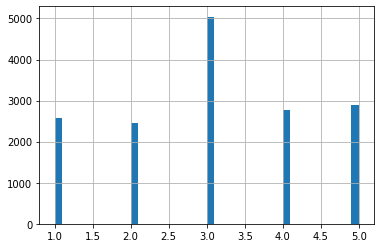

In [7]:
# TODO: Q2. Plot a histogram of review scores. These can be accessed in the df.score field in the above dataframe. Which score is the most common?
df["score"].hist(bins=40)
print("3 is the the most common value of the column score.")

If correctly plotted, you should be able to see that this is a somewhat imbalanced dataset. Let's first convert the dataset into three classes: negative, neutral, and positive sentiment:

In [8]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [9]:
class_names = ['negative', 'neutral', 'positive']

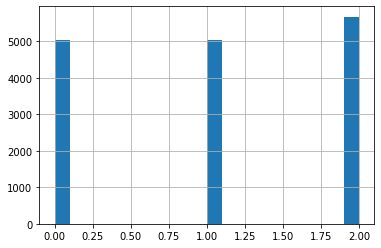

In [10]:
# TODO: Q3. Plot the histogram of review sentiments, and show that it is now approximately balanced.
df["sentiment"].hist(bins=20)

## Data Preprocessing

Let's now load a pre-trained BERT model and the corresponding tokenizer, which converts text data into tokens. 


In [11]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [12]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Let's see how tokenization works. Here is the test sentence. Convert into tokens using the `tokenizer.tokenize` and `tokenizer.convert_tokens_to_ids` methods.



In [13]:
sample_txt = 'Every day feels like the same during the lock down.'

In [14]:
# TODO: Q4. Print the tokens and token ids of the sample text above.
print(tokenizer.tokenize(sample_txt))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sample_txt)))

['Every', 'day', 'feels', 'like', 'the', 'same', 'during', 'the', 'lock', 'down', '.']
[4081, 1285, 5115, 1176, 1103, 1269, 1219, 1103, 5842, 1205, 119]


BERT has special tokens for sentence separators \[SEP\] and unknown words \[UNK\]. This can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method, which takes the test sentence and encodes it into `input_ids`.

In [15]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [16]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 4081, 1285, 5115, 1176, 1103, 1269, 1219, 1103, 5842, 1205,  119,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [17]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

Use the `tokenizer.convert_ids_to_tokens` method to invert the encoded token ids (the above tensor of length 32) and visualize the sentence.

In [18]:
# TODO: Q5. Invert the encoded token ids.
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'Every', 'day', 'feels', 'like', 'the', 'same', 'during', 'the', 'lock', 'down', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


Most reviews in the dataset contain less than around 120 tokens, but let us choose a maximum length of 160.

In [19]:
MAX_LEN = 160

# Building the dataset

Let's now create a dataset using the tokenizer. Here is some code that does this:

In [20]:
# class GPReviewDataset(Dataset):
class GPReviewDataset():
  
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data into 90-5-5 train-validation-test.

In [25]:
# TODO: Q6. Create three data frames: df_train, df_val, df_test as above and print their shapes.
shuffle_df = df.sample(frac=1.0)

rows, cols = shuffle_df.shape
split_index_1 = int(rows * 0.05)
split_index_2 = int(rows * 0.1)

df_test = shuffle_df.iloc[0: split_index_1, :]
df_val= shuffle_df.iloc[split_index_1:split_index_2, :]
df_train = shuffle_df.iloc[split_index_2: rows, :]

train_samples_size = len(df_train)
val_samples_size = len(df_val)
test_samples_size = len(df_test)

print("The shape of the traning set: ",df_train.shape)
print("The shape of the validation set: ",df_val.shape)
print("The shape of the testing set: ",df_test.shape)

print("The number of samples in training set: ",train_samples_size)
print("The number of samples in validation set: ",val_samples_size)
print("The number of samples in testing set: ",test_samples_size)

The shape of the traning set:  (14172, 12)
The shape of the validation set:  (787, 12)
The shape of the testing set:  (787, 12)
The number of samples in training set:  14172
The number of samples in validation set:  787
The number of samples in testing set:  787


We also need to create a couple of data loaders:

In [26]:
from torch.utils.data import DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [27]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# print(len(train_data_loader))
# print(len(val_data_loader))
# print(len(test_data_loader))


Let's have a look at an example batch from our training data loader:

In [28]:
import torch
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)
print(data['targets'])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])
tensor([0, 2, 1, 1, 2, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 1])


Let's now load the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Load the model using:

In [29]:
from transformers import BertModel
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And encode our sample text:

In [30]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is the sequence of hidden states of the last layer of the model. The `pooled_output` can be thought of as a summary of the content in the test sentence. Try printing out the sizes of `last_hidden_state` and `pooled_output`:

In [31]:
# TODO: Q7. Print the sizes of the hidden states and the pooled output.
print("The sizes of the hidden states: ", last_hidden_state.shape)
print("The sizes of the pooled output: ", pooled_output.shape)

The sizes of the hidden states:  torch.Size([1, 32, 768])
The sizes of the pooled output:  torch.Size([1, 768])


We can use all of this knowledge to create a classifier that uses the BERT model:

In [32]:
import torch.nn as nn
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Note that our sentiment classifier takes the BERT backbone and adds a dropout layer (for regularization) and a linear dense layer, which we train using cross-entropy. Let's create an instance and move it to the GPU:

In [33]:
device = torch.device('cuda')
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [34]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [35]:
from torch.nn import functional as F 

F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3880, 0.2686, 0.3434],
        [0.5506, 0.2484, 0.2010],
        [0.3667, 0.3850, 0.2483],
        [0.3008, 0.3867, 0.3125],
        [0.3844, 0.2969, 0.3187],
        [0.4768, 0.2033, 0.3198],
        [0.4767, 0.1381, 0.3852],
        [0.3656, 0.3089, 0.3256],
        [0.4025, 0.2819, 0.3155],
        [0.2053, 0.2775, 0.5172],
        [0.4521, 0.1833, 0.3646],
        [0.3584, 0.2365, 0.4051],
        [0.4720, 0.2088, 0.3192],
        [0.3665, 0.2788, 0.3547],
        [0.3459, 0.1729, 0.4812],
        [0.4657, 0.2086, 0.3257]], device='cuda:0', grad_fn=<SoftmaxBackward>)

Check the prediction and the target format so as to produce the correct predictions

In [36]:
  import numpy as np
  targets = data["targets"].to(device)
  outputs = model(
    input_ids=input_ids,
    attention_mask=attention_mask
  )

  _, preds = torch.max(outputs, dim=1)
  
  print(preds)
  print(targets)
  
  correct_predictions = 0
  correct_predictions += (preds == targets).sum()

  print(correct_predictions)
  n_examples = len(preds)
  
  print("data size:", len(preds))
  train_acc = correct_predictions.double() / n_examples
  print(train_acc)
  print(f'Train accuracy {train_acc}')

tensor([2, 2, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 1, 2, 2], device='cuda:0')
tensor([0, 2, 1, 1, 2, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 1], device='cuda:0')
tensor(7, device='cuda:0')
data size: 16
tensor(0.4375, device='cuda:0', dtype=torch.float64)
Train accuracy 0.4375


### Training

To train the model, we will use the AdamW optimizer and a linear learning-rate scheduler with no warmup steps, along with the cross-entropy loss. Five epochs (full passes through the training data should be enough) should be enough, but you can experiment with more epochs.

In [37]:
from transformers import AdamW
import transformers

EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

# scheduler = get_linear_schedule_with_warmup(
scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


Let's continue with writing a helper function for training our model for one epoch:

In [38]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    # TODO Q8. Complete the incomplete code snippets below to finish training.
    
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    
    correct_predictions += (preds == targets).sum()
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Let's write another function that helps us evaluate the model on a given data loader.

In [39]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  # TODO: Q9. Reproduce the above code but only evaluate the model (without any weight updates).input_ids = d["input_ids"].to(device)
  losses = []
  correct_predictions = 0  

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += (preds == targets).sum()
    losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop.

In [40]:
%%time
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  # TODO: Q10. Complete the code below to track train and test accuracy.losses

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, train_samples_size)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, val_samples_size)

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.7797234255828922 accuracy 0.640770533446232


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6337454545497895 accuracy 0.7280813214739518

Epoch 2/5
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.49418334006153164 accuracy 0.8052497883149873


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5775604197382926 accuracy 0.7928843710292249

Epoch 3/5
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.2925225176814834 accuracy 0.9066469093988145


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6026012329757213 accuracy 0.8259212198221093

Epoch 4/5
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.20565006219252155 accuracy 0.9424216765453006


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.7144597454741597 accuracy 0.841168996188056

Epoch 5/5
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.15515340510918707 accuracy 0.9588625458650861


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.705768810622394 accuracy 0.8475222363405337

CPU times: user 21min 29s, sys: 14min 55s, total: 36min 25s
Wall time: 36min 40s


Note that we're storing the best model, indicated by the highest validation accuracy.

Plot train and validation accuracy as a function of epoch count.

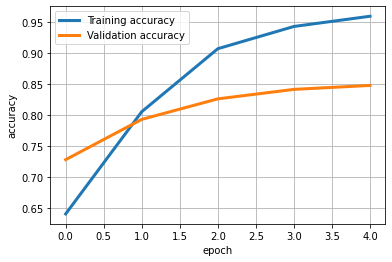

In [41]:
# TODO: Q11. Plot train/validation accuracies.
import matplotlib.pyplot as plt 

train_acc_plot = history['train_acc'];

val_acc_plot = history['val_acc'];

plt.plot(range(EPOCHS),train_acc_plot,'-',linewidth=3,label='Training accuracy')
plt.plot(range(EPOCHS),val_acc_plot,'-',linewidth=3,label='Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

You might try to fine-tune the parameters (learning rate, batch size) a bit more if accuracy is not good enough.


## Evaluation

So how good is our model on predicting sentiment?

We'll define a helper function to get the predictions from our model:

In [42]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [43]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Let us compare true sentiment vs predicted sentiment by plotting a confusion matrix of `y_test` vs `y_pred`.

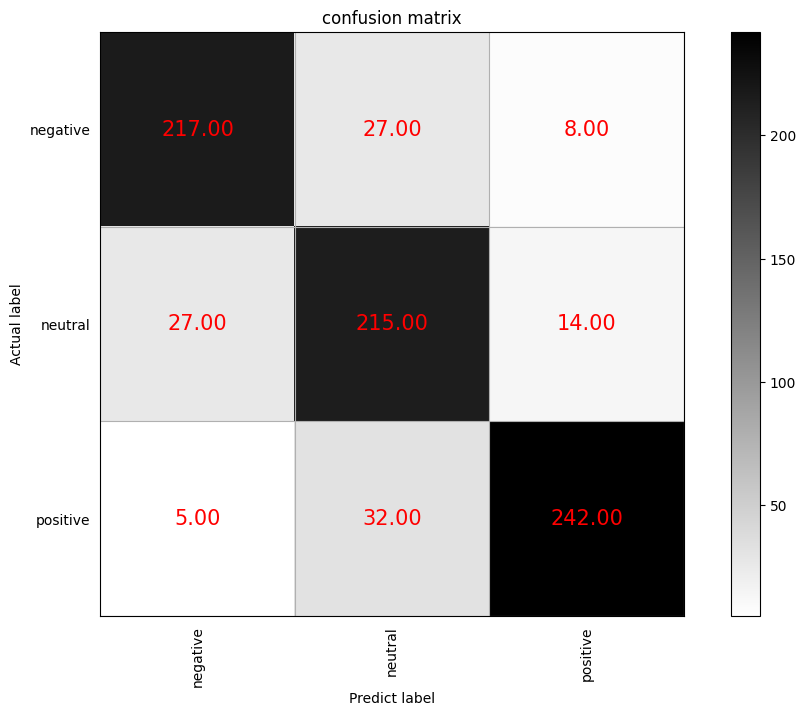

In [44]:
# TODO. Q12. Plot the 3x3 confusion matrix and show that the model finds it a bit difficult to classify neutral reviews.
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):

    plt.figure(figsize=(12, 8), dpi=100)
    np.set_printoptions(precision=2)

    # calculate the possibility value of each cell
    ind_array = np.arange(len(class_names))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=15, va='center', ha='center')
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(class_names)))
    plt.xticks(xlocations, class_names, rotation=90)
    plt.yticks(xlocations, class_names)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')
    
    # offset the tick
    tick_marks = np.array(range(len(class_names))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    
    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()

matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(matrix, 'confusion_matrix.png', title='confusion matrix')

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [45]:
review_text = "I love Deep Learning! Best course evah!!!1!!"

Use your trained model to predict the sentiment expressed in `review_text`.


In [46]:
# TODO: Q13. Print the predicted sentiment in `review_text`.
encoding = tokenizer.encode_plus(
  review_text,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)


outputs = model(
    input_ids=encoding['input_ids'].to(device), 
    attention_mask=encoding['attention_mask'].to(device)
  )

_, preds = torch.max(outputs, dim=1)
print("The prediction of the reiew_text is:", class_names[int(preds)])

The prediction of the reiew_text is: positive


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)